In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker

mpl.rcParams['font.family'] = 'arial'
mpl.rcParams['font.size'] = 14

import os
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# reproducibility
SEED = 114514

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [2]:
class PharyngealDataset(Dataset):
    
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
    
    def __len__(self):
        return self.features.shape[0]
    
    def __getitem__(self, idx):
        return self.features[idx,...], self.labels[idx], idx

In [3]:
dataset = torch.load('../dataset/data_train/20230519.pt')

# ratio of training
ratio = 0.6

n_train = int(len(dataset)*ratio)
n_test = len(dataset)-n_train
train_dataset, test_dataset = random_split(dataset, [n_train, n_test])

train_indices = train_dataset.indices
test_indices = test_dataset.indices
# Create 'sets' list
sets = [''] * len(dataset)
for idx in train_indices:
    sets[idx] = 'train'
for idx in test_indices:
    sets[idx] = 'test'

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [4]:
class LSTMModel(nn.Module):

    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.layer_dim = layer_dim
        self.hidden_dim = hidden_dim

        # LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

        # Register the max
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        # Initialize hidden state and cell state
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)

        # We need to detach as we are doing trucated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        out = self.fc(out[:, -1, :])
        out = self.softmax(out)
        return out, hn

In [6]:
# debug

# model = LSTMModel(input_dim=7, hidden_dim=100, layer_dim=1, output_dim=5).to(device)
# for features, labels in train_dataloader:
#     features = features.permute(0, 2, 1)
#     features = features.float().to(device)
#     labels = labels.long().to(device)
#     outputs = model(features)
#     print(features.shape)
#     print(labels.shape)
#     print(outputs.shape)

In [5]:
model = LSTMModel(input_dim=7, hidden_dim=100, layer_dim=1, output_dim=5).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.008)

n_epochs = 200
losses = []
val_losses = []
accuracies = []
val_accuracies = []

for epoch in range(n_epochs):
    epoch_losses = []
    correct_preds = 0
    total_preds = 0

    for i, (features, labels, _) in enumerate(train_dataloader):
        features = features.permute(0, 2, 1)
        features = features.float().to(device)
        labels = labels.long().to(device)

        # Forward pass
        outputs, _ = model(features)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Count total and correctly predicted samples
        _, predicted = torch.max(outputs.data, 1)
        total_preds += labels.size(0)
        correct_preds += (predicted == labels).sum().item()

        # Append the loss at the end of each epoch
        epoch_losses.append(loss.item())

    # Calculate training accuracy
    accuracy = correct_preds / total_preds
    accuracies.append(accuracy)

    with torch.no_grad():
        val_epoch_losses = []
        correct_preds = 0
        total_preds = 0

        for i, (features, labels, _) in enumerate(test_dataloader):
            features = features.permute(0, 2, 1)
            features = features.float().to(device)
            labels = labels.long().to(device)
            outputs, _ = model(features)
            val_loss = criterion(outputs, labels)
            val_epoch_losses.append(val_loss.item())

            _, predicted = torch.max(outputs.data, 1)
            total_preds += labels.size(0)
            correct_preds += (predicted == labels).sum().item()

        val_accuracy = correct_preds / total_preds
        val_accuracies.append(val_accuracy)
    
    if epoch == 99:
        torch.save(model.state_dict(), '../results/fig2/model/100 epochs.pt')

    avg_epoch_loss = sum(epoch_losses) / len(epoch_losses)
    avg_val_epoch_loss = sum(val_epoch_losses) / len(val_epoch_losses)
    losses.append(avg_epoch_loss)
    val_losses.append(avg_val_epoch_loss)

    if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1}/{n_epochs}, Loss: {avg_epoch_loss}, Validation loss: {avg_val_epoch_loss}\nTraining Accuracy: {accuracy}, Validation Accuracy: {val_accuracy}')

Epoch 10/200, Loss: 1.4682457447052002, Validation loss: 1.4311631917953491
Training Accuracy: 0.37142857142857144, Validation Accuracy: 0.44680851063829785
Epoch 20/200, Loss: 1.0746902028719585, Validation loss: 1.0410318970680237
Training Accuracy: 0.4857142857142857, Validation Accuracy: 0.48936170212765956
Epoch 30/200, Loss: 1.1447162628173828, Validation loss: 1.0456233024597168
Training Accuracy: 0.8285714285714286, Validation Accuracy: 0.851063829787234
Epoch 40/200, Loss: 0.841756800810496, Validation loss: 0.8498788475990295
Training Accuracy: 0.7142857142857143, Validation Accuracy: 0.6808510638297872
Epoch 50/200, Loss: 0.7619260350863138, Validation loss: 0.7068178057670593
Training Accuracy: 0.8285714285714286, Validation Accuracy: 0.8297872340425532
Epoch 60/200, Loss: 0.48584039012591046, Validation loss: 0.5865355134010315
Training Accuracy: 0.8285714285714286, Validation Accuracy: 0.851063829787234
Epoch 70/200, Loss: 0.38718247413635254, Validation loss: 0.521159514

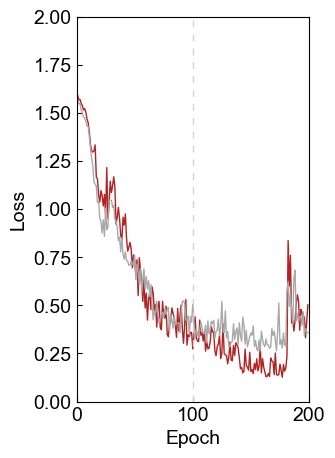

In [7]:
fig = plt.figure(figsize=[3, 5])
ax = fig.add_subplot()

ax.plot(losses, linewidth=1, c='firebrick')
ax.plot(val_losses, linewidth=1, c='darkgray')
ax.vlines(100, 0, 2,
          linewidth=1,
          linestyles=(0, (5, 5)),
          colors='lightgray')

ax.set_xlim(0, 200)
ax.set_ylim(0, 2)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.tick_params(which='both', direction='in')

plt.savefig('../results/fig3/loss.png', dpi=600, bbox_inches='tight')
plt.show()

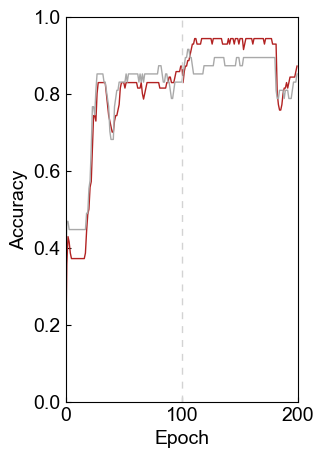

In [8]:
fig = plt.figure(figsize=[3, 5])
ax = fig.add_subplot()

ax.plot(accuracies, linewidth=1, c='firebrick')
ax.plot(val_accuracies, linewidth=1, c='darkgray')
ax.vlines(100, 0, 1,
          linewidth=1,
          linestyles=(0, (5, 5)),
          colors='lightgray')

ax.set_xlim(0, 200)
ax.set_ylim(0, 1)
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.tick_params(which='both', direction='in')

plt.savefig('../results/fig3/accuracy.png', dpi=600, bbox_inches='tight')
plt.show()

___
**Evaluation**
___

In [9]:
def eval_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    incorrect_samples = []
    with torch.no_grad():
        for features, labels, _ in dataloader:
            features = features.permute(0, 2, 1)
            features = features.float().to(device)
            labels = labels.long().to(device)

            outputs, _ = model(features)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Finding the samples for which the prediction was incorrect
            incorrect_indices = (predicted != labels).nonzero(as_tuple=True)
            incorrect_samples.extend(features[incorrect_indices].cpu().numpy())

        return correct / total, np.array(incorrect_samples)

In [10]:
train_dataloader

Accuracy of the model on the train data: 94.2857%
Samples that were incorrectly predicted:


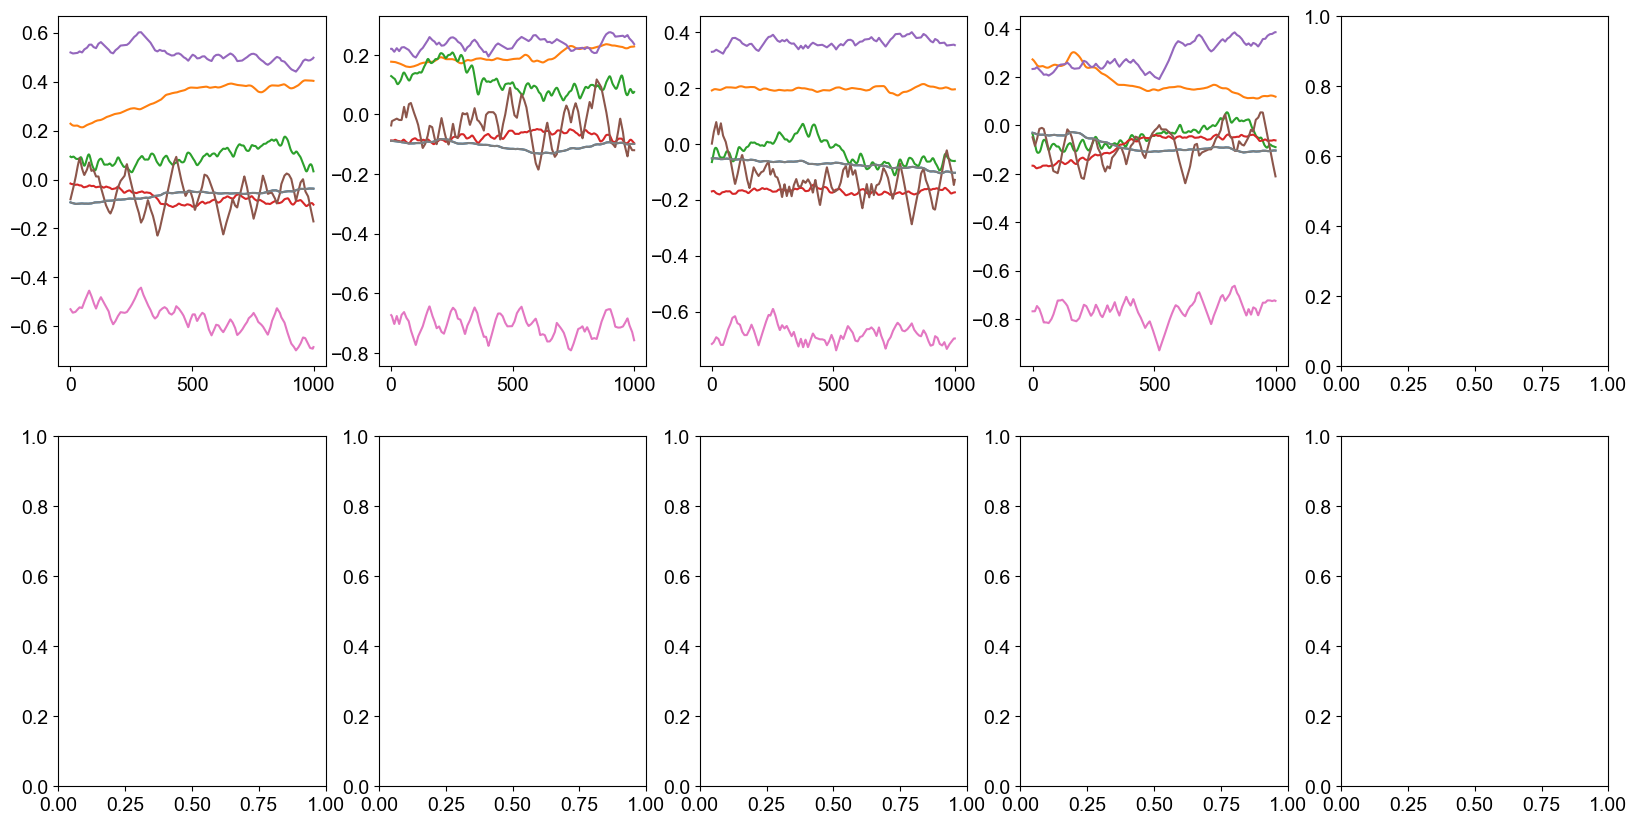

In [11]:
model = LSTMModel(input_dim=7, hidden_dim=100, layer_dim=1, output_dim=5).to(device)
model.load_state_dict(torch.load('../results/fig2/model/150 epochs.pt'))

accuracy, incorrect_samples = eval_model(model, train_dataloader)
print('Accuracy of the model on the train data: {:.4f}%'.format(100 * accuracy))
print('Samples that were incorrectly predicted:')
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=[20, 10])
for ax, sample in zip(axes.flatten(), incorrect_samples):
    ax.plot(sample)
    ax.plot(sample[:, 0])

plt.show()

Accuracy of the model on the test data: 89.36170212765957%
Samples that were incorrectly predicted:


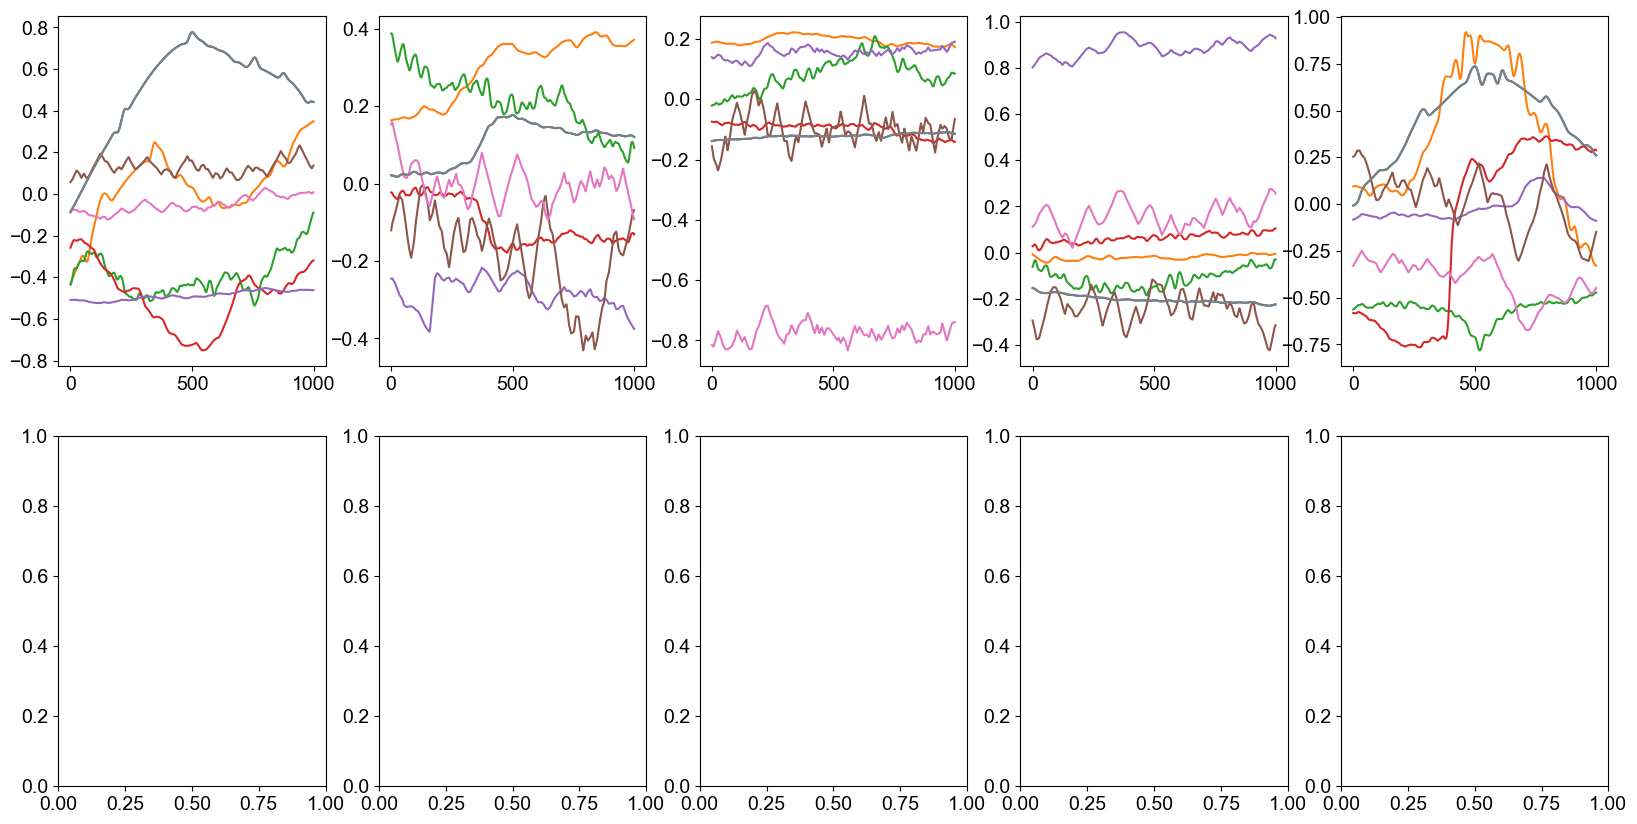

In [12]:
accuracy, incorrect_samples = eval_model(model, test_dataloader)
print('Accuracy of the model on the test data: {}%'.format(100 * accuracy))
print('Samples that were incorrectly predicted:')
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=[20, 10])
for ax, sample in zip(axes.flatten(), incorrect_samples):
    ax.plot(sample)
    ax.plot(sample[:, 0])

plt.show()

In [13]:
dataloader = DataLoader(dataset)

predictions = np.zeros(len(dataset))
ground_truth = np.zeros(len(dataset))
set_info = ['']*len(dataset)

with torch.no_grad():
    for features, labels, indices in dataloader:
        features = features.permute(0, 2, 1)
        features = features.float().to(device)

        output, _ = model(features)
        _, predicted = torch.max(output.data, 1)

        predicted = predicted.cpu().numpy()
        indices = indices.cpu().numpy()

        for idx in indices:
            set_info[idx] = sets[idx]

        predictions[indices] = predicted
        ground_truth[indices] = labels

In [14]:
set_info = np.array(set_info)

In [15]:
predictions

array([3., 3., 3., 3., 3., 3., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       4., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 4., 2., 2., 2., 2., 2., 1., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.])

In [16]:
ground_truth

array([0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.])

In [33]:
mask = (ground_truth == 4)
result_array = (predictions[mask] == 4)
set_info_result_array = set_info[mask]

In [34]:
result_array

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [35]:
set_info_result_array

array(['test', 'train', 'train', 'test', 'train', 'test', 'train',
       'train', 'test', 'train', 'train', 'test', 'train', 'train',
       'train', 'train', 'train', 'test', 'train', 'test', 'train',
       'test', 'test', 'train', 'test', 'train', 'test', 'train', 'train',
       'test', 'test', 'test', 'train', 'train', 'test', 'train', 'test',
       'test', 'test', 'train', 'test', 'test', 'train', 'train', 'train',
       'train', 'test'], dtype='<U5')

___
**Visualization**
___

In [17]:
print(model)

LSTMModel(
  (lstm): LSTM(7, 100, batch_first=True)
  (fc): Linear(in_features=100, out_features=5, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [18]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of trainable parameters: ', total_params)

Number of trainable parameters:  44105


In [19]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.numel())

lstm.weight_ih_l0 2800
lstm.weight_hh_l0 40000
lstm.bias_ih_l0 400
lstm.bias_hh_l0 400
fc.weight 500
fc.bias 5


In [21]:
# For visualization
class RawLSTMModel(nn.Module):

    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RawLSTMModel, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.layer_dim = layer_dim

        # LSTM
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True) 

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state and cell state
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)

        # Detach the hidden states to prevent backpropagation beyond this point
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Save the outputs before applying the fully connected layer
        lstm_out = out

        # We need to pass the hidden state at the last time step to the fully connected layer for classification
        out = self.fc(hn[-1])

        # Return the LSTM output, hidden states at each timestep, and final hidden state
        return hn, lstm_out, out

In [22]:
raw_model = RawLSTMModel(input_dim=7, hidden_dim=100, layer_dim=1, output_dim=5).to(device)
raw_model.load_state_dict(torch.load('../results/fig2/model/100 epochs.pt'))
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(raw_model.parameters(), lr=0.0005, weight_decay=0.008)

# n_epochs = 200
# losses = []
# for epoch in range(n_epochs):
#     epoch_losses = []
#     for i, (features, labels, _) in enumerate(train_dataloader):
#         features = features.permute(0, 2, 1)
#         features = features.float().to(device)
#         labels = labels.long().to(device)

#         # Forward pass
#         _, _, outputs = raw_model(features)
#         loss = criterion(outputs, labels)

#         # Backward pass and optimization
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         # Append the loss at the end of each epoch
#         epoch_losses.append(loss.item())

#     avg_epoch_loss = sum(epoch_losses) / len(epoch_losses)
#     losses.append(avg_epoch_loss)

#     if (epoch+1) % 10 == 0:
#         print(f'Epoch {epoch+1}/{n_epochs}, Loss: {loss.item()}')

<All keys matched successfully>

In [23]:
features, labels, idx = next(iter(train_dataloader))
features = features.permute(0, 2, 1)
features = features.float().to(device)

lstm_out, hn, output = raw_model(features)

print("LSTM output shape: ", lstm_out.shape)
print("LSTM hidden state shape: ", hn.shape)
print("FC output shape: ", output.shape)

LSTM output shape:  torch.Size([1, 32, 100])
LSTM hidden state shape:  torch.Size([32, 1000, 100])
FC output shape:  torch.Size([32, 5])


In [24]:
features.shape

torch.Size([32, 1000, 7])

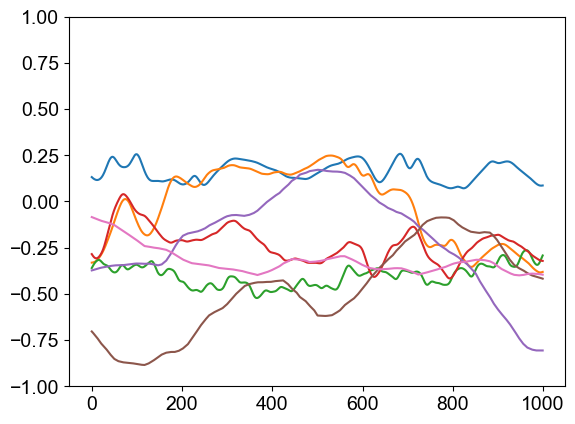

torch.Size([1000, 7])
tensor(88)


In [25]:
sample_idx = 1
plt.plot(features[sample_idx,...].to('cpu'))
plt.ylim([-1, 1])
plt.show()
print(features[sample_idx,...].to('cpu').shape)
print(idx[sample_idx])

In [20]:
labels[sample_idx].to('cpu')

tensor(2.)

In [21]:
print(torch.argmax(output[sample_idx,...].to('cpu')))

tensor(2)


In [22]:
ht_sample = hn[sample_idx,...].to('cpu').detach()
feature_sample = features[sample_idx,...].to('cpu').detach()
output_sample = output[sample_idx,...].to('cpu').unsqueeze(0).detach()
print(ht_sample.shape)
print(feature_sample.shape)
print(output_sample.shape)

torch.Size([1000, 100])
torch.Size([1000, 7])
torch.Size([1, 5])


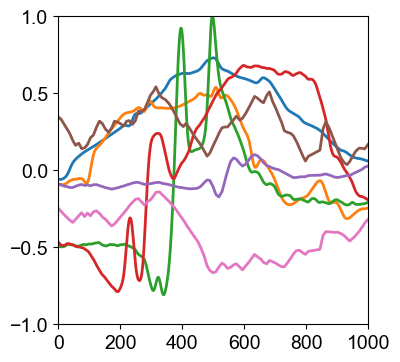

In [45]:
fig = plt.figure(figsize=[4, 4])
ax = fig.add_subplot()

ax.plot(feature_sample, linewidth=2)
ax.set_xlim(0, feature_sample.shape[0])
ax.set_ylim(-1, 1)
# ax.axis('off')

plt.savefig('../results/fig3/visualization/raw.png', dpi=600,
            bbox_inches='tight')
plt.show()

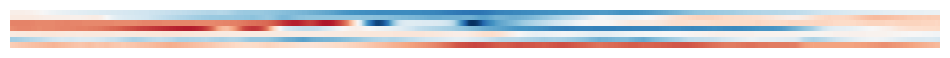

In [24]:
fig = plt.figure(figsize=[12, 0.5])
ax = fig.add_subplot()

ax.imshow(feature_sample.permute(1, 0), aspect='auto', interpolation='none',
          cmap='RdBu', vmin=-1, vmax=1)
ax.axis('off')

# plt.savefig('../results/fig3/visualization/preprocessed.png', dpi=600,
#             pad_inches=0, bbox_inches='tight')
plt.show()

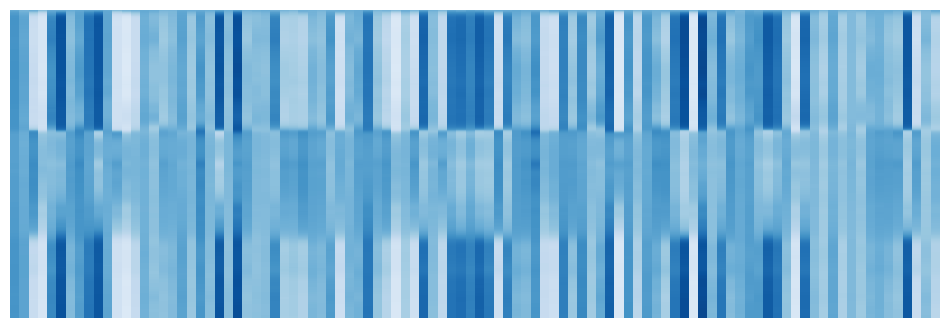

In [25]:
fig = plt.figure(figsize=[12, 4])
ax = fig.add_subplot()

ax.imshow(ht_sample, aspect='auto', interpolation='none',
          cmap='Blues', vmin=-1, vmax=1)
ax.axis('off')

# plt.savefig('../results/fig3/visualization/hidden.png', dpi=600,
#             pad_inches=0, bbox_inches='tight')
plt.show()

In [26]:
m = nn.Softmax(dim=1)
softmax_sample = m(output_sample)
softmax_sample

tensor([[0.0027, 0.0079, 0.9655, 0.0096, 0.0142]])

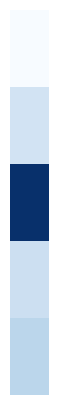

In [28]:
fig = plt.figure(figsize=[0.5, 5])
ax = fig.add_subplot()

ax.imshow(output_sample.T, aspect='auto', interpolation='none', cmap='Blues')
ax.axis('off')

# plt.savefig('../results/fig3/visualization/raw_output.png', dpi=600,
#             pad_inches=0, bbox_inches='tight')
plt.show()

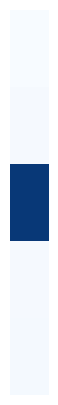

In [29]:
fig = plt.figure(figsize=[0.5, 5])
ax = fig.add_subplot()

ax.imshow(softmax_sample.T, aspect='auto', interpolation='none',
          cmap='Blues', vmin=0, vmax=1)
ax.axis('off')

# plt.savefig('../results/fig3/visualization/output.png', dpi=600,
#             pad_inches=0, bbox_inches='tight')
plt.show()

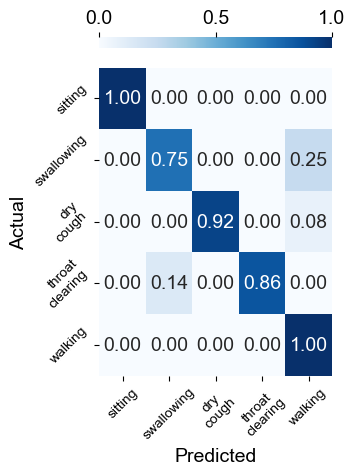

In [33]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Model evaluation mode
model.eval()

# Lists for true and predicted labels
y_true = []
y_pred = []

with torch.no_grad():
    for features, labels, _ in test_dataloader:
        features = features.permute(0, 2, 1)
        features = features.float().to(device)
        labels = labels.long().to(device)

        # Forward pass
        outputs, _ = model(features)

        _, predicted = torch.max(outputs.data, 1)

        # Transfer predictions and true labels to CPU and convert to numpy arrays
        predicted = predicted.cpu().numpy()
        labels = labels.cpu().numpy()

        # Append the labels and predictions to the lists
        y_true.extend(labels)
        y_pred.extend(predicted)

# Create a confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
cf_matrix[0] = [2, 0, 0, 0, 0] # ...

normalized_cf_matrix = cf_matrix.astype('float')/cf_matrix.sum(axis=1)[:, np.newaxis]

# Plot the confusion matrix
all_labels = ['sitting',
              'swallowing',
              'dry\ncough',
              'throat\nclearing',
              'walking']

plt.figure(figsize=(3,5))
sns.heatmap(normalized_cf_matrix,
            annot=True,
            cmap='Blues',
            fmt='.2f',
            xticklabels=all_labels,
            yticklabels=all_labels,
            cbar_kws=dict(location='top'))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(size=10, rotation=45)
plt.yticks(size=10, rotation=45)


plt.savefig('../results/fig3/confusion_matrix.png', dpi=600, bbox_inches='tight')
plt.show()